In [294]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

72.00694410957968


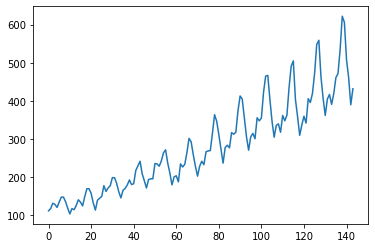

72.00694410957968


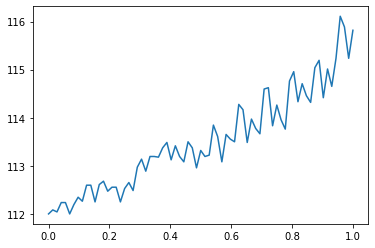

In [295]:
# ---- data loading and pre-processing ---- #

import polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

# read in time series into temporary list
temp = []
f = open('DataSets/AirPassengers.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
data = pla.bottom_up_pla(temp,1)
pla.display_trends(data, 112)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 8
train_proportion = 0.8

# segment the data into input output pairs that we will use to train the model
def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length, 2):
        inputs.append(data[i:(i+seq_length)]) # the next n are the input
        outputs.append(data[i+seq_length:i+seq_length+1]) # and the one after that is the output
    return Variable(torch.Tensor(np.array(inputs))), Variable(torch.Tensor(np.array(outputs)))
    
# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)
trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [296]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(seq_length, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


Epoch: 0/300, loss: 0.8429628014564514
Epoch: 30/300, loss: 0.28850415349006653
Epoch: 60/300, loss: 0.16348563134670258
Epoch: 90/300, loss: 0.09628116339445114
Epoch: 120/300, loss: 0.04477182775735855
Epoch: 150/300, loss: 0.023965774103999138
Epoch: 180/300, loss: 0.012676840648055077
Epoch: 210/300, loss: 0.006026340648531914
Epoch: 240/300, loss: 0.0023687928915023804
Epoch: 270/300, loss: 0.0013028186513110995
Epoch: 300/300, loss: 0.0007496451726183295


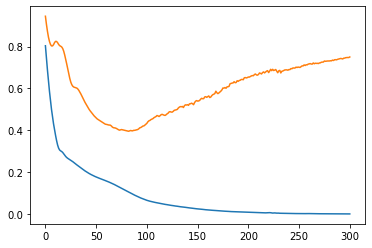

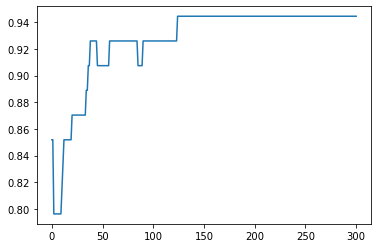

Lowest validation loss: 0.3959101140499115 at epoch 82


In [297]:
# training

epochs = 300

import torch.optim as optim
train_loss = []
validation_loss = []

epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 1000000 # the lowest validation loss
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_direction_accuracy = []
validation_direction_accuracy = []
for epoch in range(epochs+1):

    # this is the validation part, ideally we wouldn't do this every epoch, but it's easy and
    # gives good insight into when the model overfits
    for data in testset:
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        output = net(features.view(-1,seq_length))  # get a prediction from the model
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        epoch_total_trainloss += loss.item()/len(testset)
    
    if epoch_total_trainloss < min_val_loss:
        min_val_loss = epoch_total_trainloss
        min_val_loss_epoch = epoch

    validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
    epoch_total_trainloss = 0 # reset this for the validation epoch'''
    for data in trainset:  # for each batch
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        output = net(features.view(-1,seq_length))  # get a prediction from the model
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)  # sum the losses of this epoch
    
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch

    # now we'll calculate the direction accuracy for the training and validation sets
    correct=0
    for data in test:
        inputs, labels = data
        output = net(inputs.view(-1,seq_length))
        output = output[0]
        if output[0] < 0 and labels[0] < 0 or output[0] > 0 and labels[0] > 0:
            correct += 1
            #print(output[0],labels[0])
    validation_direction_accuracy.append(correct/len(test))

    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")


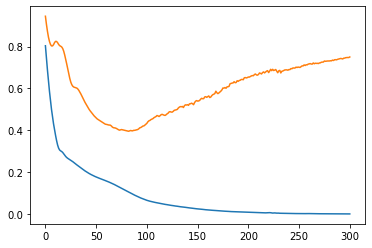

Directional Accuracy: 92.85714285714286, Average Loss: 0.7490593315544954


In [298]:
# test
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()

with torch.no_grad():
    correct = 0
    i = 0
    X, Y = [], []
    X2, Y2 = [], []
    total_loss = 0
    for data in test:
        inputs, labels = data
        output = net(inputs.view(-1,seq_length))
        net.zero_grad()
        total_loss += F.mse_loss(output[0], labels).item()
        output = output[0]
        if output[0] < 0 and labels[0] < 0 or output[0] > 0 and labels[0] > 0:
            correct += 1
            #print(output[0],labels[0])
    print(f'Directional Accuracy: {correct*100/len(test)}, Average Loss: {total_loss/len(test)}')


